In [58]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
def get_structure_contours_from_structure_volumes_v3(volumes, stack, sections, 
                                                     resolution, level, sample_every=1,
                                                    use_unsided_name_as_key=False):
    """
    Re-section atlas volumes and obtain structure contours on each section.
    Resolution of output contours are in volume resolution.
    v3 supports multiple levels.

    Args:
        volumes (dict of (3D array, 3-tuple)): {structure: (volume, origin_wrt_wholebrain)}. volume is a 3d array of probability values.
        sections (list of int):
        resolution (int): resolution of input volumes.
        level (float or dict or dict of list): the cut-off probability at which surfaces are generated from probabilistic volumes. Default is 0.5.
        sample_every (int): how sparse to sample contour vertices.

    Returns:
        Dict {section: {name_s: contour vertices}}.
    """

    from collections import defaultdict
    
    structure_contours_wrt_alignedBrainstemCrop_rawResol = defaultdict(lambda: defaultdict(dict))

    converter = CoordinatesConverter(stack=stack, section_list=metadata_cache['sections_to_filenames'][stack].keys())

    converter.register_new_resolution('structure_volume', resol_um=convert_resolution_string_to_um(resolution=resolution, stack=stack))
    converter.register_new_resolution('image', resol_um=convert_resolution_string_to_um(resolution='raw', stack=stack))
    
    for name_s, (structure_volume_volResol, origin_wrt_wholebrain_volResol) in volumes.iteritems():

        converter.derive_three_view_frames(name_s, 
        origin_wrt_wholebrain_um=convert_resolution_string_to_um(resolution=resolution, stack=stack) * origin_wrt_wholebrain_volResol,
        zdim_um=convert_resolution_string_to_um(resolution=resolution, stack=stack) * structure_volume_volResol.shape[2])

        positions_of_all_sections_wrt_structureVolume = converter.convert_frame_and_resolution(
        p=np.array(sections)[:,None],
        in_wrt=('wholebrain', 'sagittal'), in_resolution='section',
        out_wrt=(name_s, 'sagittal'), out_resolution='structure_volume')[..., 2].flatten()
            
        structure_ddim = structure_volume_volResol.shape[2]
        
        valid_mask = (positions_of_all_sections_wrt_structureVolume >= 0) & (positions_of_all_sections_wrt_structureVolume < structure_ddim)
        if np.count_nonzero(valid_mask) == 0:
#             sys.stderr.write("%s, valid_mask is empty.\n" % name_s)
            continue

        positions_of_all_sections_wrt_structureVolume = positions_of_all_sections_wrt_structureVolume[valid_mask]
        positions_of_all_sections_wrt_structureVolume = np.round(positions_of_all_sections_wrt_structureVolume).astype(np.int)
        
        if isinstance(level, dict):
            level_this_structure = level[name_s]
        else:
            level_this_structure = level

        if isinstance(level_this_structure, float):
            level_this_structure = [level_this_structure]
                        
        for one_level in level_this_structure:

            contour_2d_wrt_structureVolume_sectionPositions_volResol = \
            find_contour_points_3d(structure_volume_volResol >= one_level,
                                    along_direction='sagittal',
                                    sample_every=sample_every,
                                    positions=positions_of_all_sections_wrt_structureVolume)

            for d_wrt_structureVolume, cnt_uv_wrt_structureVolume in contour_2d_wrt_structureVolume_sectionPositions_volResol.iteritems():

                contour_3d_wrt_structureVolume_volResol = np.column_stack([cnt_uv_wrt_structureVolume, np.ones((len(cnt_uv_wrt_structureVolume),)) * d_wrt_structureVolume])

    #             contour_3d_wrt_wholebrain_uv_rawResol_section = converter.convert_frame_and_resolution(
    #                 p=contour_3d_wrt_structureVolume_volResol,
    #                 in_wrt=(name_s, 'sagittal'), in_resolution='structure_volume',
    #                 out_wrt=('wholebrain', 'sagittal'), out_resolution='image_image_section')

                contour_3d_wrt_alignedBrainstemCrop_uv_rawResol_section = converter.convert_frame_and_resolution(
                    p=contour_3d_wrt_structureVolume_volResol,
                    in_wrt=(name_s, 'sagittal'), in_resolution='structure_volume',
                    out_wrt=('wholebrainXYcropped', 'sagittal'), out_resolution='image_image_section')

                assert len(np.unique(contour_3d_wrt_alignedBrainstemCrop_uv_rawResol_section[:,2])) == 1
                sec = int(contour_3d_wrt_alignedBrainstemCrop_uv_rawResol_section[0,2])

                if use_unsided_name_as_key:
                    name = convert_to_unsided_label(name_s)
                else:
                    name = name_s

                structure_contours_wrt_alignedBrainstemCrop_rawResol[sec][name][one_level] = contour_3d_wrt_alignedBrainstemCrop_uv_rawResol_section[..., :2]
        
    return structure_contours_wrt_alignedBrainstemCrop_rawResol

# Generate manuscript figure

In [8]:
# CHATM2 section 106 shows 5N/7N/Amb, ROI: x=8112,y=8960,w=8608,h=6608
# CHATM2 section 162 shows 6N/10N/12N, ROI: x=10560,y=9552,w=8368,h=3072

In [9]:
# img = DataManager.load_image_v2(stack='CHATM2', prep_id=2, resol='raw', version='CHATJpeg', section=106)

version = 'NtbNormalizedAdaptiveInvertedGammaJpeg'
# version = 'CHATJpeg'
sec = 162
img = DataManager.load_image_v2(stack='CHATM2', prep_id=2, resol='raw', version=version, section=sec)
viz0 = gray2rgb(img)

Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_raw_CHATJpeg/CHATM2_slide53_2018_01_22-S3_prep2_raw_CHATJpeg.jpg


In [10]:
for stack in ['CHATM2']:
    
    section_margin_um = 500.
    section_margin = int(section_margin_um / SECTION_THICKNESS)

    valid_secmin = np.min(metadata_cache['valid_sections'][stack])
    valid_secmax = np.max(metadata_cache['valid_sections'][stack])

    chat_structures_df = DataManager.load_annotation_v4(stack=stack, by_human=True, 
                                                   suffix='structuresHanddrawn', 
                                                   timestamp='latest')

    chat_structures_df = chat_structures_df[~chat_structures_df['volume'].isnull()]

    chat_structures, chat_structure_resolution = \
    convert_structure_annotation_to_volume_origin_dict_v2(structures_df=chat_structures_df, 
                                                          out_resolution='10.0um', stack=stack)

#     for structure_m in ['Amb_L', '5N_L', '7N_L']:
#     for structure_m in ['6N_L', '10N_L', '12N']:
    for structure_m in ['12N']:

        stack_m_spec = dict(name='atlasV6',
                           vol_type='score',
                           structure=structure_m,
                            resolution='10.0um'
                           )

        stack_f_spec = dict(name=stack,
                           vol_type='score',
                           detector_id=799,
                           structure=convert_to_original_name(structure_m),
                            resolution='10.0um'
                           )

        local_alignment_spec = dict(stack_m=stack_m_spec, 
                              stack_f=stack_f_spec,
                              warp_setting=27)

        vo = DataManager.load_transformed_volume_v2(alignment_spec=local_alignment_spec, return_origin_instead_of_bbox=True)

        registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners = \
        load_json('/home/yuncong/' + stack + '_registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners.json')

        (_, _, secmin), (_, _, secmax) = registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners[structure_m]

        atlas_structures_wrt_wholebrainWithMargin_sections = \
        range(max(secmin - section_margin, valid_secmin), min(secmax + 1 + section_margin, valid_secmax))

        levels = [0.1, 0.25, 0.5, 0.75, 0.99]

        contours_all_sections_all_structures_all_levels = \
        get_structure_contours_from_structure_volumes_v3(volumes={structure_m: vo}, stack=stack, 
                                                         sections=atlas_structures_wrt_wholebrainWithMargin_sections,
                                                        resolution='10.0um', level=levels, sample_every=5)

        ####################################

        chat_vo = chat_structures[structure_m]

        chat_contours_all_sections_all_structures_all_levels = \
        get_structure_contours_from_structure_volumes_v3(volumes={structure_m: chat_vo}, stack=stack, 
                                                         sections=atlas_structures_wrt_wholebrainWithMargin_sections,
                                                        resolution='10.0um', level=[.5], sample_every=1)

        ####################################

        # prep2 because at end of get_structure_contours_from_structure_volumes_v2 we used wholebrainXYcropped

#         for sec, contours_all_structures_all_levels in sorted(contours_all_sections_all_structures_all_levels.items()):
#         for sec, contours_all_structures_all_levels in [(106, contours_all_sections_all_structures_all_levels[106])]:

        contours_all_structures_all_levels = contours_all_sections_all_structures_all_levels[sec]

        if is_invalid(sec=sec, stack=stack):
            continue

#             for version in ['NtbNormalizedAdaptiveInvertedGammaJpeg', 'CHATJpeg']:
#             for version in ['CHATJpeg']:
#                 img = DataManager.load_image_v2(stack=stack, prep_id=2, resol='raw', version=version, section=sec)

        for name_s, cnt_all_levels in contours_all_structures_all_levels.iteritems():
#                     viz = gray2rgb(img)
#                     for level, cnt in cnt_all_levels.iteritems():
#                         cv2.polylines(viz, [cnt.astype(np.int)], isClosed=True, color=LEVEL_TO_COLOR_LINE[level], thickness=10)

#                     fp = os.path.join('/home/yuncong/' + stack + '_atlas_aligned_multilevel', name_s, version, stack + '_' + name_s + '_' + version + '_' + ('%03d' % sec) + '.jpg')
#                     print fp
#                     create_parent_dir_if_not_exists(fp)
#                     imsave(fp, viz)

#                     # Add CHAT contour
#                     if sec in chat_contours_all_sections_all_structures_all_levels:
#                         chat_cnt = chat_contours_all_sections_all_structures_all_levels[sec][name_s][.5]
#                         cv2.polylines(viz, [chat_cnt.astype(np.int)], isClosed=True, color=(255,255,255), thickness=20)

#                     fp = os.path.join('/home/yuncong/' + stack + '_atlas_aligned_multilevel_down16', name_s, version, stack + '_' + name_s + '_' + version + '_' + ('%03d' % sec) + '.jpg')
#                     print fp
#                     create_parent_dir_if_not_exists(fp)
#                     imsave(fp, viz[::16, ::16])

            #######################

            for level, cnt in cnt_all_levels.iteritems():
                cv2.polylines(viz0, [cnt.astype(np.int)], isClosed=True, color=LEVEL_TO_COLOR_LINE[level], thickness=10)

            if sec in chat_contours_all_sections_all_structures_all_levels:
                chat_cnt = chat_contours_all_sections_all_structures_all_levels[sec][name_s][.5]
                cv2.polylines(viz0, [chat_cnt.astype(np.int)], isClosed=True, color=(255,255,255), thickness=20)

                #######################



aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/CHATM2" "/home/yuncong/CSHL_labelings_v3/CHATM2" --exclude "*" --include "*structuresHanddrawn*"
0
latest timestamp:  05122018234101


In [11]:
fp = os.path.join('/home/yuncong/' + stack + '_atlas_aligned_multilevel_all_structures', version, stack + '_' + version + '_' + ('%03d' % sec) + '.jpg')
print fp
create_parent_dir_if_not_exists(fp)
imsave(fp, viz0)

/home/yuncong/CHATM2_atlas_aligned_multilevel_all_structures/CHATJpeg/CHATM2_CHATJpeg_161.jpg


In [12]:
fp = os.path.join('/home/yuncong/' + stack + '_atlas_aligned_multilevel_down16_all_structures', version, stack + '_' + version + '_' + ('%03d' % sec) + '.jpg')
print fp
create_parent_dir_if_not_exists(fp)
imsave(fp, viz0[::16, ::16])

/home/yuncong/CHATM2_atlas_aligned_multilevel_down16_all_structures/CHATJpeg/CHATM2_CHATJpeg_161.jpg


# Summarize amount of deviation from CHAT

In [81]:
deviation_x_from_chat_um_per_structure_all_stacks = defaultdict(lambda: defaultdict(dict))
deviation_y_from_chat_um_per_structure_all_stacks = defaultdict(lambda: defaultdict(dict))
deviation_z_from_chat_um_per_structure_all_stacks = defaultdict(lambda: defaultdict(dict))
deviation_3d_from_chat_um_per_structure_all_stacks = defaultdict(lambda: defaultdict(dict))


for stack in ['CHATM2', 'CHATM3']:
# for stack in ['CHATM2']:
    
#     stack = 'CHATM2' # 05092018200440
    # stack = 'CHATM3' # 05092018203614

    chat_structures_df = DataManager.load_annotation_v4(stack=stack, by_human=True, 
                                                   suffix='structuresHanddrawn', 
                                                   timestamp='latest')

    chat_structures_df = chat_structures_df[~chat_structures_df['volume'].isnull()]

    chat_structures, chat_structure_resolution = \
    convert_structure_annotation_to_volume_origin_dict_v2(structures_df=chat_structures_df, 
                                                          out_resolution='10.0um', stack=stack)

    deviation_from_chat_um_per_structure = {}

#     for name_s, (v_chat, o_chat) in sorted(chat_structures.items()):
    for name_s in ['5N_L', '5N_R', '6N_L', '6N_R', '7N_L', '7N_R', 'Amb_L', 'Amb_R', '10N_L', '10N_R', '12N']:
        
        (v_chat, o_chat) = chat_structures[name_s]
        
#         if name_s in ['3N_L', '3N_R', '4N_L', '4N_R']:
#             continue

        chat_centroid = get_centroid_3d(v_chat) + o_chat
#         chat_centroid = o_chat

        stack_m_spec = dict(name='atlasV6',
                       vol_type='score',
                       structure=name_s,
                        resolution='10.0um'
                       )

        stack_f_spec = dict(name=stack,
                           vol_type='score',
                           detector_id=799,
                           structure=convert_to_original_name(name_s),
                            resolution='10.0um'
                           )

        local_alignment_spec = dict(stack_m=stack_m_spec, 
                              stack_f=stack_f_spec,
                              warp_setting=27)

        v_alg, o_alg = DataManager.load_transformed_volume_v2(alignment_spec=local_alignment_spec, 
                                                      return_origin_instead_of_bbox=True)
        alg_centroid = get_centroid_3d(v_alg) + o_alg
#         alg_centroid = o_alg

#         print name_s, chat_centroid, alg_centroid, chat_centroid - alg_centroid, np.linalg.norm(chat_centroid - alg_centroid), 'x 10.0um'

        deviation_3d_from_chat_um_per_structure_all_stacks[stack][name_s] = np.linalg.norm(chat_centroid - alg_centroid) * 10.
        deviation_x_from_chat_um_per_structure_all_stacks[stack][name_s] = np.abs(chat_centroid[0] - alg_centroid[0]) * 10.
        deviation_y_from_chat_um_per_structure_all_stacks[stack][name_s] = np.abs(chat_centroid[1] - alg_centroid[1]) * 10.
        deviation_z_from_chat_um_per_structure_all_stacks[stack][name_s] = np.abs(chat_centroid[2] - alg_centroid[2]) * 10.
            

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/CHATM2" "/home/yuncong/CSHL_labelings_v3/CHATM2" --exclude "*" --include "*structuresHanddrawn*"
0
latest timestamp:  05122018234101
aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/CHATM3" "/home/yuncong/CSHL_labelings_v3/CHATM3" --exclude "*" --include "*structuresHanddrawn*"
0
latest timestamp:  05102018152000


In [96]:
pd.DataFrame(deviation_3d_from_chat_um_per_structure_all_stacks).to_csv('/home/yuncong/Dropbox/BrainProjectFiguresByTopic/Registration/compare_with_CHAT/measurements/deviation_3d_from_chat_um_per_structure_all_stacks.csv')
pd.DataFrame(deviation_x_from_chat_um_per_structure_all_stacks).to_csv('/home/yuncong/Dropbox/BrainProjectFiguresByTopic/Registration/compare_with_CHAT/measurements/deviation_rostralCaudal_from_chat_um_per_structure_all_stacks.csv')
pd.DataFrame(deviation_y_from_chat_um_per_structure_all_stacks).to_csv('/home/yuncong/Dropbox/BrainProjectFiguresByTopic/Registration/compare_with_CHAT/measurements/deviation_dorsalVentral_from_chat_um_per_structure_all_stacks.csv')
pd.DataFrame(deviation_z_from_chat_um_per_structure_all_stacks).to_csv('/home/yuncong/Dropbox/BrainProjectFiguresByTopic/Registration/compare_with_CHAT/measurements/deviation_lateralMedial_from_chat_um_per_structure_all_stacks.csv')

In [82]:
import pandas as pd

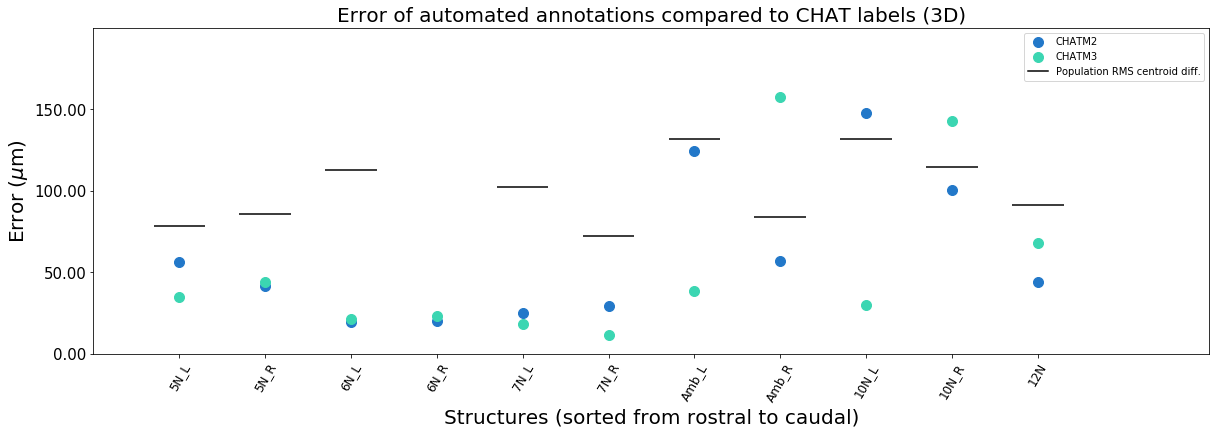

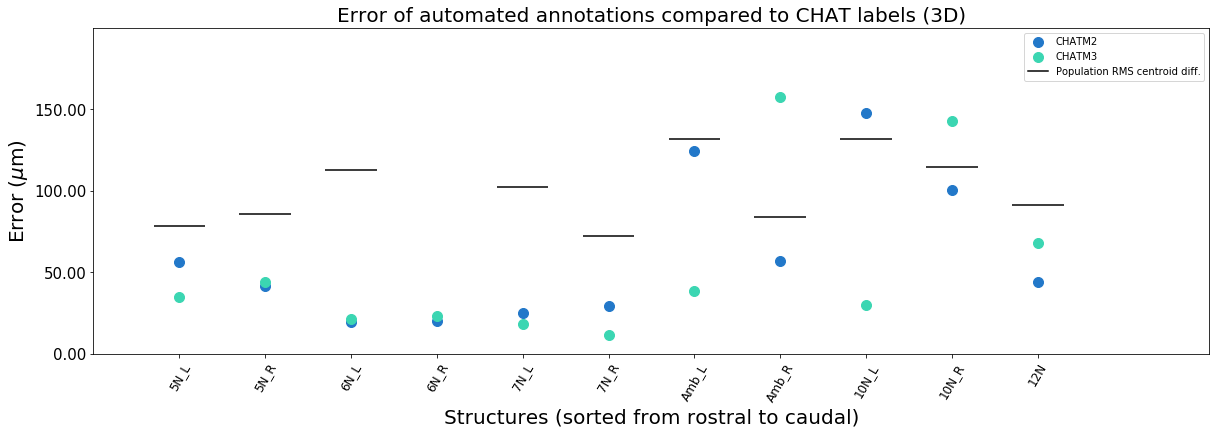

In [84]:
fig, ax = plot_by_stack_by_structure(deviation_3d_from_chat_um_per_structure_all_stacks, 
#                            structures=sorted(deviation_from_chat_um_per_structure.keys()), 
                           structures=['5N_L', '5N_R', '6N_L', '6N_R', '7N_L', '7N_R', 'Amb_L', 'Amb_R', '10N_L', '10N_R', '12N'],
                          yticks=np.arange(0, 150+10, 50),
                          ylabel='Error ($\mu$m)',
                                     xlabel='Structures (sorted from rostral to caudal)',
                        title='Error of automated annotations compared to CHAT labels (3D)');

rms_3d_all_structures = pd.read_csv('/home/yuncong/Dropbox/BrainProjectFiguresByTopic/UpdateAtlas/measurements/population_rms_3d_all_structures_outlierRemoved.csv', index_col=0, header=None)[1].to_dict()

# bar_height = [std_rostral_caudal_all_structures[s] 
bar_height = [rms_3d_all_structures[s] 
for s in ['5N_L', '5N_R', '6N_L', '6N_R', '7N_L', '7N_R', 'Amb_L', 'Amb_R', '10N_L', '10N_R', '12N']]

ax.hlines(y=bar_height, xmin=np.arange(-.3, -.3+len(bar_height)), xmax=np.arange(.3, .3+len(bar_height)+1));

import matplotlib.lines as mlines
black_line = mlines.Line2D([], [], color='black', label='Population RMS centroid diff.')
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels)
# import matplotlib.patches as mpatches
# red_patch = mpatches.Rectangle(xy=(0,0), width=1, height=1, angle=0.0, color='black', label='Population std var')
ax.legend(handles=handles + [black_line]);

fig

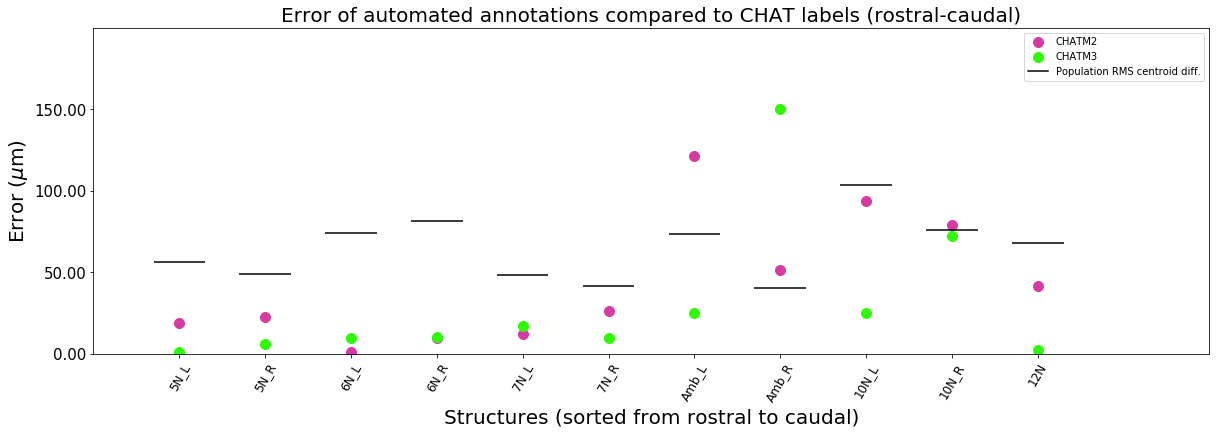

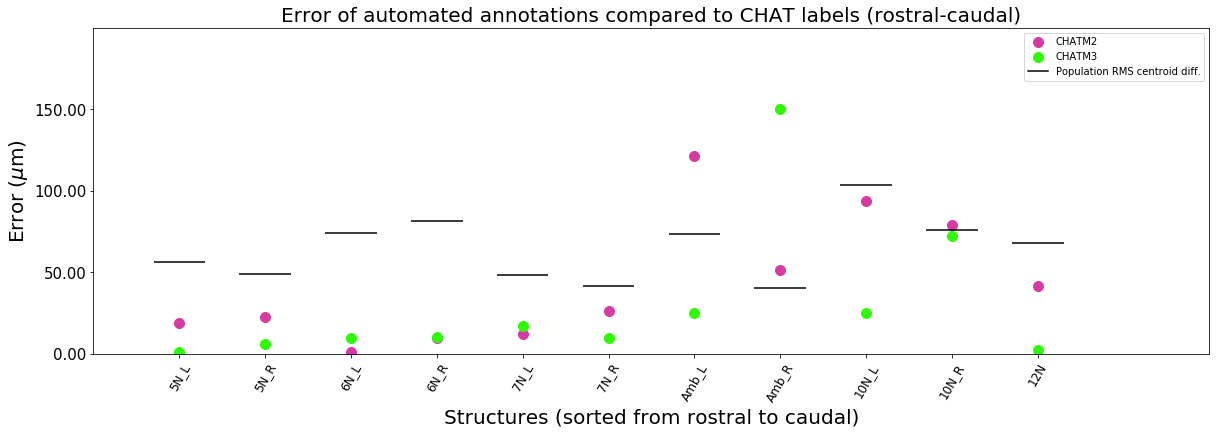

In [89]:
fig, ax = plot_by_stack_by_structure(deviation_x_from_chat_um_per_structure_all_stacks, 
#                            structures=sorted(deviation_from_chat_um_per_structure.keys()), 
                           structures=['5N_L', '5N_R', '6N_L', '6N_R', '7N_L', '7N_R', 'Amb_L', 'Amb_R', '10N_L', '10N_R', '12N'],
                          yticks=np.arange(0, 150+10, 50),
                          ylabel='Error ($\mu$m)',
                                     xlabel='Structures (sorted from rostral to caudal)',
                        title='Error of automated annotations compared to CHAT labels (rostral-caudal)')

rms_x_all_structures = pd.read_csv('/home/yuncong/Dropbox/BrainProjectFiguresByTopic/UpdateAtlas/measurements/population_rms_x_all_structures_outlierRemoved.csv', index_col=0, header=None)[1].to_dict()

# bar_height = [std_rostral_caudal_all_structures[s] 
bar_height = [rms_x_all_structures[s] 
for s in ['5N_L', '5N_R', '6N_L', '6N_R', '7N_L', '7N_R', 'Amb_L', 'Amb_R', '10N_L', '10N_R', '12N']]

ax.hlines(y=bar_height, xmin=np.arange(-.3, -.3+len(bar_height)), xmax=np.arange(.3, .3+len(bar_height)+1));

import matplotlib.lines as mlines
black_line = mlines.Line2D([], [], color='black', label='Population RMS centroid diff.')
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels)
# import matplotlib.patches as mpatches
# red_patch = mpatches.Rectangle(xy=(0,0), width=1, height=1, angle=0.0, color='black', label='Population std var')
ax.legend(handles=handles + [black_line]);

fig

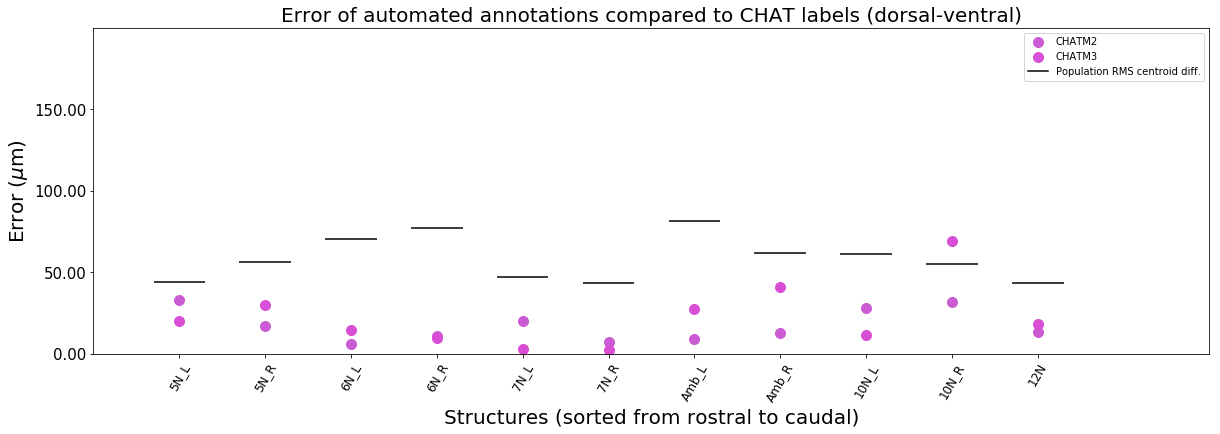

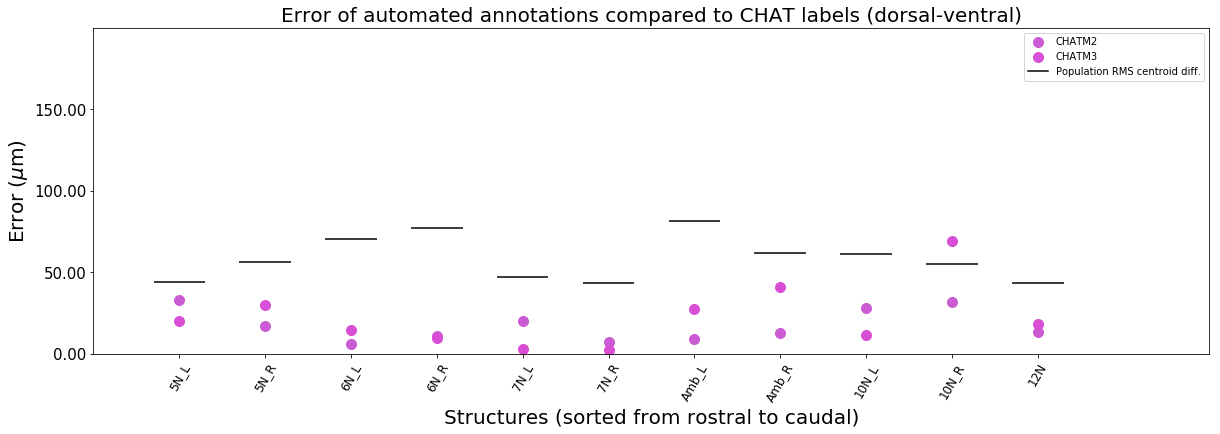

In [90]:
fig, ax = plot_by_stack_by_structure(deviation_y_from_chat_um_per_structure_all_stacks, 
#                            structures=sorted(deviation_from_chat_um_per_structure.keys()), 
                           structures=['5N_L', '5N_R', '6N_L', '6N_R', '7N_L', '7N_R', 'Amb_L', 'Amb_R', '10N_L', '10N_R', '12N'],
                          yticks=np.arange(0, 150+10, 50),
                          ylabel='Error ($\mu$m)',
                                     xlabel='Structures (sorted from rostral to caudal)',
                        title='Error of automated annotations compared to CHAT labels (dorsal-ventral)')

rms_y_all_structures = pd.read_csv('/home/yuncong/Dropbox/BrainProjectFiguresByTopic/UpdateAtlas/measurements/population_rms_y_all_structures_outlierRemoved.csv', index_col=0, header=None)[1].to_dict()

# bar_height = [std_rostral_caudal_all_structures[s] 
bar_height = [rms_y_all_structures[s] 
for s in ['5N_L', '5N_R', '6N_L', '6N_R', '7N_L', '7N_R', 'Amb_L', 'Amb_R', '10N_L', '10N_R', '12N']]

ax.hlines(y=bar_height, xmin=np.arange(-.3, -.3+len(bar_height)), xmax=np.arange(.3, .3+len(bar_height)+1));

import matplotlib.lines as mlines
black_line = mlines.Line2D([], [], color='black', label='Population RMS centroid diff.')
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels)
# import matplotlib.patches as mpatches
# red_patch = mpatches.Rectangle(xy=(0,0), width=1, height=1, angle=0.0, color='black', label='Population std var')
ax.legend(handles=handles + [black_line]);

fig

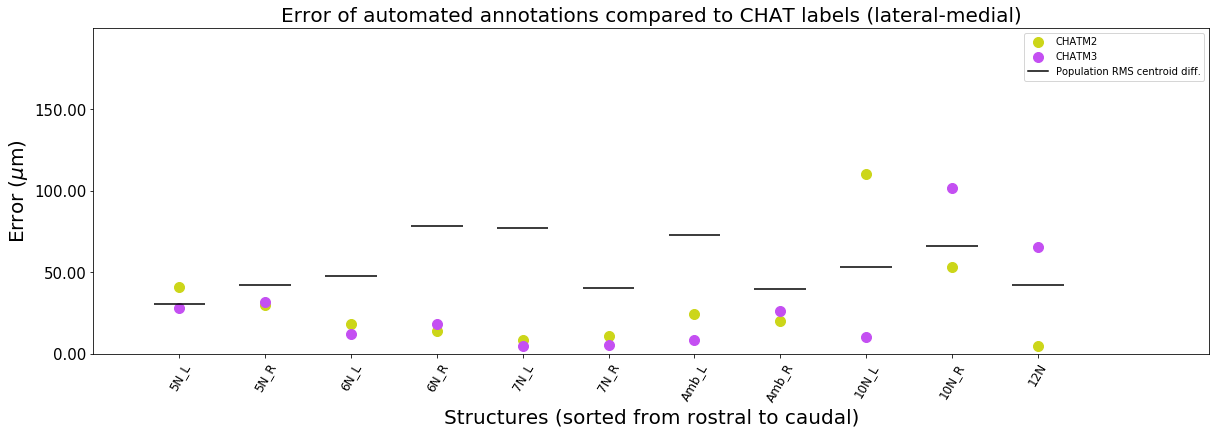

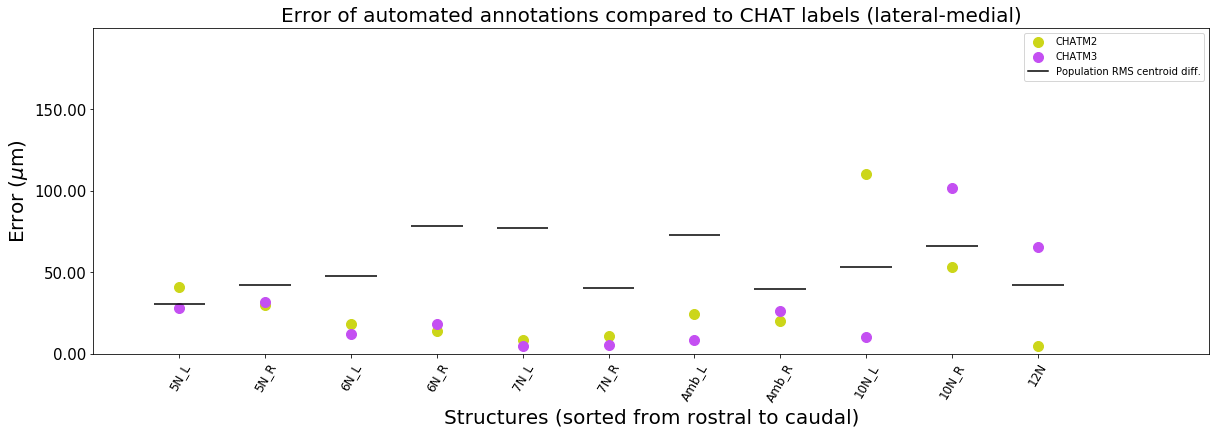

In [91]:
fig, ax = plot_by_stack_by_structure(deviation_z_from_chat_um_per_structure_all_stacks, 
#                            structures=sorted(deviation_from_chat_um_per_structure.keys()), 
                           structures=['5N_L', '5N_R', '6N_L', '6N_R', '7N_L', '7N_R', 'Amb_L', 'Amb_R', '10N_L', '10N_R', '12N'],
                          yticks=np.arange(0, 150+10, 50),
                          ylabel='Error ($\mu$m)',
                                     xlabel='Structures (sorted from rostral to caudal)',
                        title='Error of automated annotations compared to CHAT labels (lateral-medial)')

rms_z_all_structures = pd.read_csv('/home/yuncong/Dropbox/BrainProjectFiguresByTopic/UpdateAtlas/measurements/population_rms_z_all_structures_outlierRemoved.csv', index_col=0, header=None)[1].to_dict()

# bar_height = [std_rostral_caudal_all_structures[s] 
bar_height = [rms_z_all_structures[s] 
for s in ['5N_L', '5N_R', '6N_L', '6N_R', '7N_L', '7N_R', 'Amb_L', 'Amb_R', '10N_L', '10N_R', '12N']]

ax.hlines(y=bar_height, xmin=np.arange(-.3, -.3+len(bar_height)), xmax=np.arange(.3, .3+len(bar_height)+1));

import matplotlib.lines as mlines
black_line = mlines.Line2D([], [], color='black', label='Population RMS centroid diff.')
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels)
# import matplotlib.patches as mpatches
# red_patch = mpatches.Rectangle(xy=(0,0), width=1, height=1, angle=0.0, color='black', label='Population std var')
ax.legend(handles=handles + [black_line]);

fig